### Описание
Данные имеют следующую структуру:
- записываются для каждого пользователя, совершившего покупки, каждый день
- для каждой даты есть своя папка, внутри неё – папки для каждого пользователя
- внутри каждой папки есть файл data.csv, где и хранятся данные
Схематично выглядит так:

└── data
   ├── 2020-12-30
   │  ├── FirstName_LastName1
   │  │   └── data.csv
   │  ├── FirstName_LastName2
   │  │   └── data.csv
   │  └── FirstName_LastName3
   │      └── data.csv
   └── 2020-12-31
      ├── FirstName_LastName1
      │   └── data.csv
      └── FirstName_LastName5
          └── data.csv

### 1 задача
Соберите все данные из папки data в один датафрэйм, имеющий следующие столбцы: колонки из самих файлов (product_id, quantity), а также имя пользователя (name), и дата этих покупок (date), соответствует названию папки, где лежит папка с пользователем).
В качестве ответа укажите сумму по колонке quantity.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import os

In [2]:
os.getcwd()  #текущая директория

'/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-asfandijarova/my_projects'

In [3]:
#data_12_03 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-asfandijarova/shared/homeworks/python_ds_miniprojects/4/data/2020-12-03/Alexey_Smirnov/data.csv')

In [4]:
data = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-asfandijarova/shared/homeworks/python_ds_miniprojects/4/data'

In [5]:
os.listdir(data)  #для себя

['2020-12-05',
 '2020-12-08',
 '2020-12-09',
 '2020-12-04',
 '2020-12-06',
 '2020-12-03',
 '2020-12-07']

In [6]:
all_data = []

In [7]:
#data\2020-12-03\Alexey_Smirnov\file.csv

for date_folder in os.listdir(data):  
    for user in os.listdir(data + '/' + date_folder):  #путь корневой папки + путь папки даты = путь папки даты (где все юзеры)
        for data_file in os.listdir(data + '/' + date_folder + '/' + user):  #ныряем глубже и заходим в папку первого юзера
            path_to_file = data + '/' + date_folder + '/' + user + '/' + data_file #для чтения csv в пути нужно прописать и сам файл! 
            
            csv_file = pd.read_csv(path_to_file)  #извлекаем фрейм
            
            csv_file['name'] = user
            csv_file['date'] = date_folder
            
            all_data.append(csv_file)  #кидаем очередной фрейм

In [8]:
result_df = pd.concat(all_data)  #объединим все фреймы
result_df

,Unnamed: 0,product_id,quantity,name,date
0,0,27,4,Petr_Ivanov,2020-12-05
1,1,89,1,Petr_Ivanov,2020-12-05
2,2,33,2,Petr_Ivanov,2020-12-05
3,3,8,3,Petr_Ivanov,2020-12-05
4,4,16,1,Petr_Ivanov,2020-12-05
...,...,...,...,...,...
0,0,18,4,Petr_Fedorov,2020-12-07
1,1,94,4,Petr_Fedorov,2020-12-07
0,0,95,2,Vasiliy_Ivanov,2020-12-07
1,1,83,3,Vasiliy_Ivanov,2020-12-07


In [10]:
result_df.drop(columns='Unnamed: 0', inplace=True)
result_df['date'] = pd.to_datetime(result_df['date'])

In [11]:
sum_quantity = result_df.quantity.sum()
sum_quantity

480

### 2 задача
Выясните, какой пользователь купил больше всего товаров. Если их несколько, то перечислите имена через запятую с пробелом и в алфавитном порядке.

In [12]:
total_quantities = result_df.groupby('name', as_index=False) \
    .agg({'quantity':'sum'}) \
    .rename(columns={'quantity':'total'}) \
    .sort_values('total', ascending=False)

max_quan_user = total_quantities.iloc[0, 1]
max_quan_user

52

In [13]:
max_users = sorted(total_quantities.query('total == @max_quan_user').name)
max_users

['Alexey_Smirnov', 'Petr_Smirnov']

### 3 задача
Найдите топ-10 товаров по числу проданных единиц за всё время и постройте барплот (столбчатую диаграмму, sns.barplot), где:
- по оси x – идентификаторы товаров (product_id) 
- по оси y – суммарное число их покупок (сколько товаров с таким product_id было продано)
 
В качестве ответа укажите, сколько было продано единиц товара с product_id равным 56.

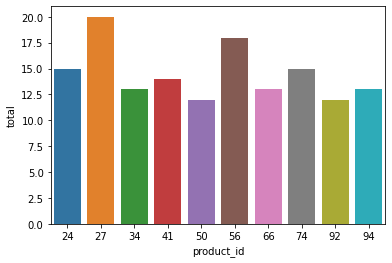

In [14]:
products = result_df.groupby('product_id', as_index=False) \
    .agg({'quantity':'sum'}) \
    .rename(columns={'quantity':'total'}) \
    .sort_values('total', ascending=False)

top_10 = products.head(10)

sns.barplot(x='product_id', y='total', data=top_10)

In [15]:
top_10.query('product_id == 56')

,product_id,total
42,56,18


### 4 задача
Посмотрим на продажи по дням! Для визуализации снова используйте барплот, только теперь по оси x будут дни (date). 

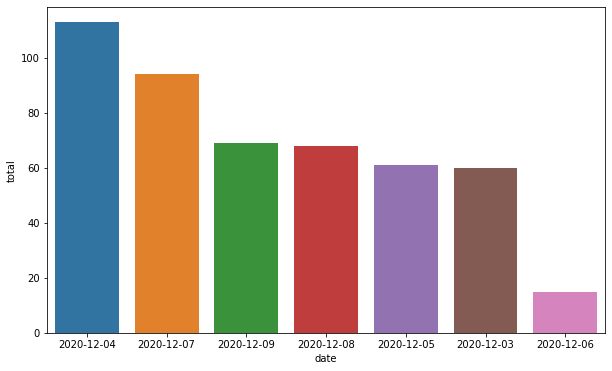

In [11]:
date_sales = result_df.groupby('date', as_index=False) \
    .agg({'quantity':'sum'}) \
    .rename(columns={'quantity':'total'}) \
    .sort_values('total', ascending=False) 

plt.figure(figsize=(10, 6))  
sns.barplot(x='date', y='total', data=date_sales)

### 5 задача
Сколько пользователей приобрели какой-либо товар повторно (более 1 раза)? Повтором будем считать покупку товара с одинаковым product_id, совершенную в разные дни. 

In [17]:
df_unique = result_df.drop_duplicates(subset=['name', 'product_id', 'date'])

In [18]:
unique_sales = df_unique.groupby(['product_id', 'name'], as_index=False) \
    .date.nunique() \
    .query('date > 1') 

unique_sales

,product_id,name,date
24,15,Anton_Ivanov,2
150,94,Petr_Fedorov,2


### Дополнительная задача
Имеется таблица с записями о компаниях, включая их ИНН, и отдельный текстовый файл с набором ИНН (колонка head_inn), которые хранятся в папке 4_inn.
- inn.xls — таблица в экселевском формате
- necessary_inn.txt — перечень необходимых ИНН в текстовом формате

Укажите сумму колонки income,RUB в отобранных данных. У набора данных necessary_inn.txt нет заголовка, поэтому вам пригодится аргумент header=None. 

In [21]:
inn = pd.read_excel('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-asfandijarova/shared/homeworks/python_ds_miniprojects/4_inn/inn.xls')

In [24]:
inn

,Unnamed: 0,#,name,reg_number,address,head,head_job,head_inn,phone,email,site,registration_date,nalogoplatelschik_code,oktmo_code,okato_code,registration_region,okato_name,field,"capital,RUB","income,RUB"
0,0,0,"ЗАО «Власова, Макаров и Шашков»",1143692580560,"д. Кирово-Чепецк, пр. Металлургов, д. 537 к. 3...",Жданов Карл Виленович,Маммолог,109092209811,+7 (559) 338-87-76,bogdanovavtonom@yahoo.com,ooo.info,2015-01-07,2006-10-04,21112877268,73423615032,Ulan-Ude,"к. Тосно, ул. Пушкинская, д. 896, 617222",Синхронизация критически важных отношений,54875526078,32205872896
1,1,1,"РАО «Тимофеева, Алексеева и Кузнецова»",9342309660697,"г. Арзамас, наб. Фестивальная, д. 7 стр. 8/2, ...",Рожков Харлампий Алексеевич,Воспитатель,704229465069,8 (632) 620-8879,safonovantonin@rao.org,ooo.net,1990-05-16,2019-01-18,18393547520,19072454279,Tyoply Stan,"ст. Кяхта, бул. Нефтяников, д. 24, 768742",Формирование заказных методик,33876448811,47437574301
2,2,2,РАО «Юдин-Ефимова»,1277485323451,"п. Меренга, алл. Достоевского, д. 3/4 к. 497, ...",Филимон Фадеевич Дьячков,Автослесарь,267655036377,+74925330378,kdorofeev@npo.ru,ao.com,1982-11-04,1986-06-19,56104355836,18629292792,Danilov,"клх Усолье Сибирское, алл. Шишкина, д. 3/9 к. ...",Максимизация корпоративных метрик,94073834991,7701710065
3,3,3,Доронин Инкорпорэйтед,7139161431511,"д. Иваново, ул. Красных Партизан, д. 83 к. 4, ...",Крылов Глеб Якубович,Тюремный надзиратель,362024991175,+7 118 643 21 48,nkulakova@mail.ru,ooo.ru,2005-01-02,2004-04-06,10398489351,32502585383,Beryozovsky,"г. Заводоуковск, ул. Гражданская, д. 7 к. 8/5,...",Разработка ориентированных на пользователя инт...,86971505490,61148002572
4,4,4,Объединенная энергетическая компания,6114798049639,"к. Энгельс, наб. Шишкина, д. 120, 823828",Субботин Вячеслав Федотович,Инженер-электрик,257948948010,8 642 249 2134,evgraf_18@yahoo.com,gerasimova.biz,1983-07-02,1992-06-20,20074507047,40083207999,Bavly,"к. Соль-Илецк, пер. Пригородный, д. 804 к. 1/3...",Монетизация интуитивных веб-сервисов,36351136214,34861533393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,2105,2105,"ИП «Зайцев, Шубин и Дементьева»",6580539599719,"к. Чебаркуль, бул. Кольцевой, д. 19 к. 3, 911953",Назар Гордеевич Миронов,Дефектолог,575321775842,8 (390) 976-88-54,juvenali_66@ao.edu,aviakompanija.edu,2007-02-01,2014-10-29,13383530491,62100202894,Gudermes,"г. Миасс, пр. Пожарского, д. 39 стр. 880, 386211",Охват прозрачных методик,88659854892,61232741869
2106,2106,2106,Юдина Лтд,5012825137426,"д. Темрюк, ш. Автомобилистов, д. 9 стр. 59, 80...",Игнатов Кирилл Арсенович,Прозектор,703895742672,+7 854 489 5577,gavrila_2019@gmail.com,npo.net,1973-08-13,2001-11-09,40544984216,35386922447,Tver,"к. Мыс Шмидта, алл. Комарова, д. 257 стр. 3, 8...",Увеличение кроссплатформенных действий,20441750025,67450329265
2107,2107,2107,Антонова Лимитед,7659150538516,"г. Ноябрьск, пр. Весенний, д. 418, 214696",Александров Радим Ярославович,Дознаватель,576824176737,+7 (135) 034-6805,chernovlongin@rambler.ru,krilov.net,2018-11-03,2016-06-15,39266483828,21174514029,Sharypovo,"с. Щелково, алл. Попова, д. 143 к. 811, 155684",Мотивация сенсационных решений,9278989412,77350481806
2108,2108,2108,ООО «Хохлов Казаков»,9506828156265,"к. Липецк, наб. Халтурина, д. 60, 449290",Воробьев Сидор Фролович,Снайпер,157426408379,+7 172 548 4422,qpanova@hotmail.com,oao.org,1980-07-02,2009-11-23,76945273610,95601014531,Privolzhskiy,"п. Токма, ш. 50 лет Победы, д. 730, 791941",Охват серверных результатов,84921082372,85023560472


In [56]:
necessary_inn = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-r-asfandijarova/shared/homeworks/python_ds_miniprojects/4_inn/necessary_inn.txt', header = None, names=['number_inn'])

In [57]:
necessary_inn

,number_inn
0,394609645484
1,281578625230
2,923769811917
3,998694734508
4,271011690615
...,...
110,664306216794
111,991951385204
112,129413497752
113,447901012904


In [60]:
list_inn = necessary_inn.number_inn.tolist()  #список инн (для удобного сравнения)

In [ ]:
#извлечь из таблицы записи с ИНН, указанными в текстовом файле

filter_inn = inn.query('head_inn in @list_inn')

In [61]:
#записать результат в файл selected_inn.csv

filter_inn.to_csv('selected_inn.csv')

In [65]:
new_data = pd.read_csv('selected_inn.csv')

In [67]:
sum_income = new_data['income,RUB'].sum()